In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC 
from sklearn.preprocessing import StandardScaler as std
from sklearn.metrics import classification_report

In [4]:
#Method to load images
def loadImages(path):
    imageList = os.listdir(path)
    loadedimages=[]
    for image in imageList:
        img = cv2.imread(path+image)
        loadedimages.append(img)
    return loadedimages

In [5]:
horses = loadImages('/home/abhi/Image Datasets/Assignment3/Train/Horses/')

In [6]:
# Checking if images are loaded
for each in horses:
    if each is None:
        print("No")

In [7]:
def gray(img):
    grayImage = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return grayImage 

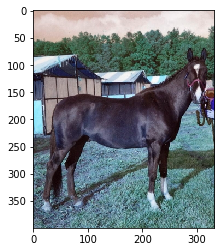

In [8]:
plt.imshow(horses[0],cmap='gray')

In [9]:
bikes = loadImages('/home/abhi/Image Datasets/Assignment3/Train/Bikes/')

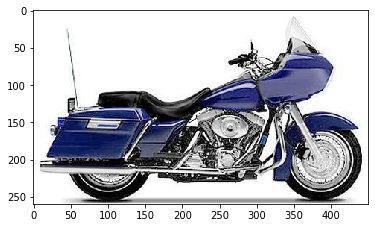

In [10]:
plt.imshow(bikes[0])

In [11]:
len(bikes)

56

In [12]:
sift = cv2.xfeatures2d.SIFT_create()
def getFeatures(img):
    kp,des = sift.detectAndCompute(img,mask=None)
    return kp,des

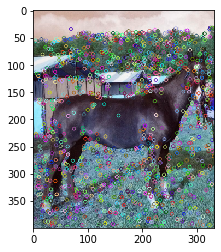

In [13]:
#Testing method getFeature
kp,des=getFeatures(horses[0])
feat=cv2.drawKeypoints(horses[0],kp,(0,255,0))
plt.imshow(feat,cmap='gray')

In [14]:
# Converting all images to grayScale
for i in range(len(horses)):
    horses[i] = gray(horses[i])
    bikes[i] = gray(bikes[i])

In [21]:
# Getting feature vectors for all images (first for horses and then bikes)
#kplist = []
#deslist = []

for images in bikes:
        kp,des = getFeatures(images)
        kplist.append(kp)
        deslist.append(des)

In [22]:
len(deslist)

112

In [23]:
# Creating label dictionary and training label
name={}
name ={0:'horse',1:'bike'}

Y = []
for i in range(len(horses)):
    Y.append(0)
for i in range(len(bikes)):
    Y.append(1)
Y = np.asarray(Y,'uint8')

In [24]:
Y.shape

(112,)

In [25]:
# restructuring descriptor list 
def restructure(l):
    vStack = np.array(l[0])
    for remaining in l[1:]:
        vStack = np.vstack((vStack, remaining))
    #descriptor_vstack = vStack.copy()
    return vStack

In [26]:
X = restructure(deslist)

In [27]:
X.shape

(113179, 128)

In [28]:
# Using KMeans to cluster features
nclusters = 32
kmeans = KMeans(nclusters)
kret_labels = kmeans.fit_predict(X)

In [29]:
kret_labels

array([16, 20, 11, ...,  2,  2,  2], dtype=int32)

In [30]:
def bow(n_images, descriptor_list, n_clusters, kmeans_ret = None):

    mega_histogram = np.array([np.zeros(n_clusters) for i in range(n_images)])
    old_count = 0
    for i in range(n_images):
        l = len(descriptor_list[i])
        for j in range(l):
            idx = kmeans_ret[old_count+j]
            mega_histogram[i][idx] += 1
        old_count += l
    print ("Vocabulary Histogram Generated")
    return mega_histogram
        

In [31]:
n_images=112
megahist = bow(n_images,deslist,nclusters,kret_labels)

Vocabulary Histogram Generated


In [32]:
#ploting vocabulary

def plotHist(n_clusters, vocabulary = None):
        print ("Plotting histogram")

        x_scalar = np.arange(n_clusters)
        y_scalar = np.array([abs(np.sum(vocabulary[:,h], dtype=np.int32)) for h in range(n_clusters)])

        print (y_scalar)

        plt.bar(x_scalar, y_scalar)
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.title("Complete Vocabulary Generated")
        plt.xticks(x_scalar + 0.4, x_scalar)
        plt.show()

Plotting histogram
[3024 2873 4874 4294 3716 4051 3965 2741 4100 3654 3188 4090 2365 2367
 4233 3468 2990 4438 2984 4797 3643 2850 2736 3613 3408 2946 2614 5017
 2689 3855 4097 3499]


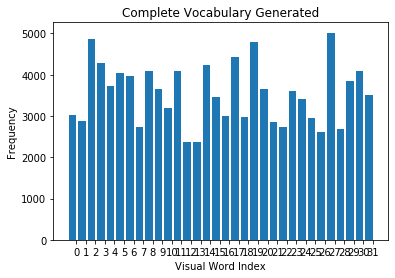

In [33]:
plotHist(nclusters,megahist)

In [34]:
# Scaling 
scale = std().fit(megahist)
megahist = scale.transform(megahist)

In [35]:
megahist.shape

(112, 32)

In [36]:
# Training SVM over BOV

svc = SVC()
svc.fit(megahist,Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [45]:
# With 32 words
print(classification_report(svc.predict(megahist),Y))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        52
           1       0.95      0.88      0.91        60

    accuracy                           0.91       112
   macro avg       0.91      0.91      0.91       112
weighted avg       0.91      0.91      0.91       112



## Test

In [37]:
#Loading Test data

horses_test = loadImages('/home/abhi/Image Datasets/Assignment3/Test/Horses/')
bikes_test = loadImages('/home/abhi/Image Datasets/Assignment3/Test/Bikes/')

In [38]:
len(horses_test)
len(bikes_test)


24

In [39]:
# Unifying test data and creating Y_test
test = []
y = []
#for each in bikes_test:
for i in range(10):
    test.append(bikes_test[i])
    y.append(1)
#for each in horses_test:
for i in range(20):
    test.append(horses_test[i])
    y.append(0)
for i in range(14):
    test.append(bikes_test[i+10])
    y.append(1)
for i in range(23):
    test.append(horses_test[i+20])
    y.append(0)
y = np.asarray(y,'uint8')
len(test)

67

In [40]:
# Converting all to gray
for i in range(len(test)):
    test[i] = gray(test[i])

In [42]:
# Classfying each Image

prediction = []
for each in test:
    prediction.append(classify(each))
    
    

In [44]:
prediction

[array([1], dtype=uint8),
 array([0], dtype=uint8),
 array([1], dtype=uint8),
 array([1], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([1], dtype=uint8),
 array([1], dtype=uint8),
 array([1], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([1], dtype=uint8),
 array([0], dtype=uint8),
 array([1], dtype=uint8),
 array([1], dtype=uint8),
 array([1], dtype=uint8),
 array([1], dtype=uint8),
 array([1], dtype=uint8),
 array([1], dtype=uint8),
 array([0], 

In [41]:
# Method to classify a image based on created BoW
def classify(img):
    kp,des = getFeatures(img)
    word_strength = np.array([[0 for i in range(nclusters)]])
    word_labels = kmeans.predict(des)
    for each in word_labels:
        word_strength[0][each]+=1
    word_strength = scale.transform(word_strength)
    prediction = svc.predict(word_strength)
    return prediction
    

In [51]:
# With 2 words
print(classification_report(prediction,y))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75        37
           1       0.71      0.57      0.63        30

    accuracy                           0.70        67
   macro avg       0.70      0.69      0.69        67
weighted avg       0.70      0.70      0.70        67



In [63]:
# With 8 words
print(classification_report(prediction,y))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86        52
           1       0.54      0.87      0.67        15

    accuracy                           0.81        67
   macro avg       0.75      0.83      0.76        67
weighted avg       0.86      0.81      0.82        67



In [75]:
# With 16 words
print(classification_report(prediction,y))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90        48
           1       0.71      0.89      0.79        19

    accuracy                           0.87        67
   macro avg       0.83      0.87      0.85        67
weighted avg       0.88      0.87      0.87        67



In [43]:
# With 32 words
print(classification_report(prediction,y))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90        50
           1       0.67      0.94      0.78        17

    accuracy                           0.87        67
   macro avg       0.82      0.89      0.84        67
weighted avg       0.90      0.87      0.87        67



In [155]:
import pickle
outfile = open('modelkmeans','wb')
pickle.dump(kmeans,outfile)
outfile.close()

In [156]:
outfile = open('modelsvc','wb')
pickle.dump(svc,outfile)
outfile.close()

In [157]:
outfile = open('modelstd','wb')
pickle.dump(scale,outfile)
outfile.close()